In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

### Data Augmentation (Rotate each image to 90, 180, 270) [1 image ---> 8 images]

In [2]:
# import os
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, save_img

# def rotate_and_save(image, save_dir, base_name, angles):
#     for angle in angles:
#         # Rotate image using tf.image.rot90 (rotates counterclockwise by 90 degrees increments)
#         rotated_image = tf.image.rot90(image, k=angle // 90)
#         file_name = f"{base_name}_rot{angle}.png"
#         save_path = os.path.join(save_dir, file_name)
#         save_img(save_path, rotated_image)

# def augment_images(base_dir, categories, target_size=(224, 224)):
#     angles = [0, 90, 180, 270]
#     for category in categories:
#         img_dir = os.path.join(base_dir, category)
#         save_dir = os.path.join(base_dir, f"{category}_augmented")
#         os.makedirs(save_dir, exist_ok=True)
        
#         for img_name in os.listdir(img_dir):
#             if img_name.endswith('.png'):
#                 img_path = os.path.join(img_dir, img_name)
#                 img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
#                 img_array = img_to_array(img)
#                 base_name = os.path.splitext(img_name)[0]
#                 rotate_and_save(img_array, save_dir, base_name, angles)

# base_dir = 'C:\\Users\\Θάνος\\Desktop\\Thesis Thanasis\\data\\clouds'
# categories = ['Healthy', 'Large Damage', 'Medium Damage', 'Minor Damage']

# augment_images(base_dir, categories)

In [3]:
base_dir = 'C:\\Users\\Θάνος\\Desktop\\Thesis Thanasis\\data_aug_3'
#clear_dir = os.path.join(base_dir, 'clear')
#clouds_dir = os.path.join(base_dir, 'clouds')

subfolders = ['clear', 'clouds']
categories = ['Healthy_augmented', "Damaged_Augmented"]
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 8

### Display some images from the clear_train_generator

In [4]:
def load_data(base_dir, subfolders, categories, img_height, img_width):
    data = []
    labels = []
    for category in categories:
        class_num = categories.index(category)
        clear_path = os.path.join(base_dir, subfolders[0], category)
        clouds_path = os.path.join(base_dir, subfolders[1], category)
        clear_images = sorted(os.listdir(clear_path))
        clouds_images = sorted(os.listdir(clouds_path))
        
        for clear_img_name, clouds_img_name in zip(clear_images, clouds_images):
            if clear_img_name.endswith('.png') and clouds_img_name.endswith('.png'):
                clear_img_path = os.path.join(clear_path, clear_img_name)
                clouds_img_path = os.path.join(clouds_path, clouds_img_name)
                
                clear_img = tf.keras.preprocessing.image.load_img(clear_img_path, target_size=(img_height, img_width))
                clouds_img = tf.keras.preprocessing.image.load_img(clouds_img_path, target_size=(img_height, img_width))
                
                clear_img_array = tf.keras.preprocessing.image.img_to_array(clear_img)
                clouds_img_array = tf.keras.preprocessing.image.img_to_array(clouds_img)
                
                combined_img = np.stack((clear_img_array, clouds_img_array), axis=0)
                
                data.append(combined_img)
                labels.append(class_num)
    return np.array(data), np.array(labels)

data, labels = load_data(base_dir, subfolders, categories, IMG_HEIGHT, IMG_WIDTH)

In [5]:
data.shape

(6040, 2, 64, 64, 3)

In [6]:
# Normalize the images
data = data / 255.0

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(categories))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(categories))

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")

Training data shape: (4832, 2, 64, 64, 3)
Validation data shape: (1208, 2, 64, 64, 3)
Training labels shape: (4832, 2)
Validation labels shape: (1208, 2)


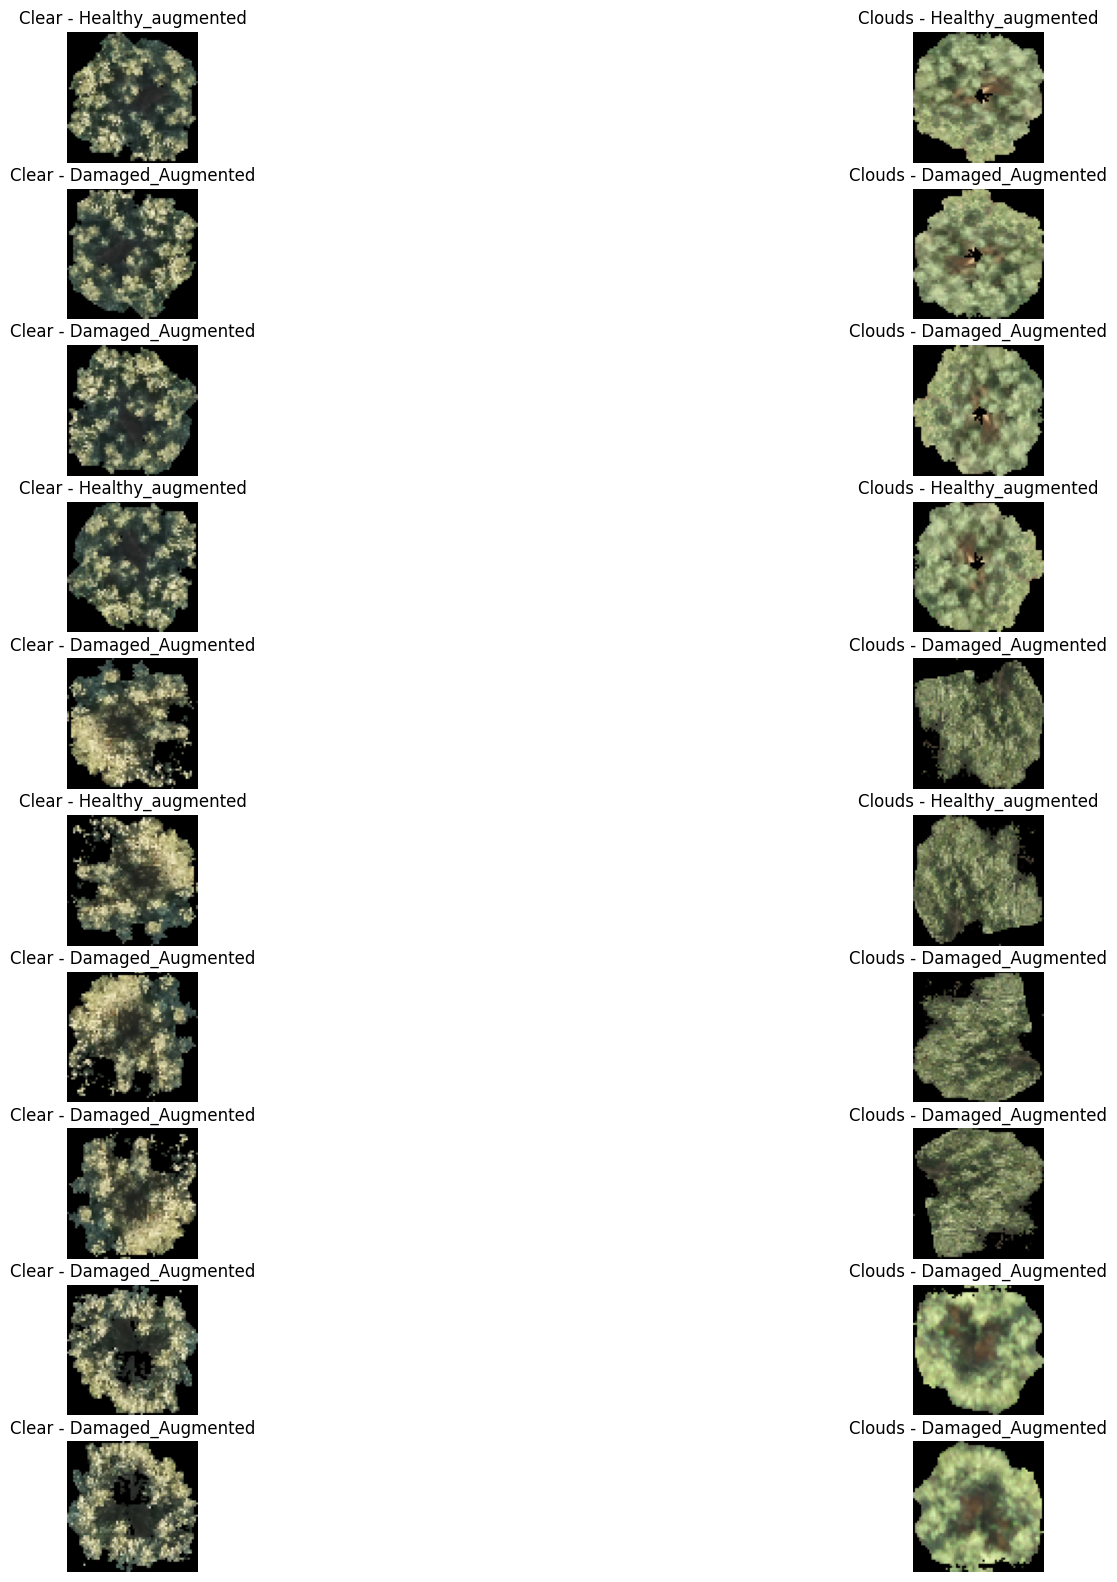

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_image_sets(data, labels, categories, num_sets=10):
    plt.figure(figsize=(20, num_sets * 2))
    for i in range(num_sets):
        # Clear image
        ax = plt.subplot(num_sets, 2, 2 * i + 1)
        plt.imshow(data[i, 0, :, :, :])
        plt.title(f"Clear - {categories[np.argmax(labels[i])]}")
        plt.axis("off")
        
        # Clouds image
        ax = plt.subplot(num_sets, 2, 2 * i + 2)
        plt.imshow(data[i, 1, :, :, :])
        plt.title(f"Clouds - {categories[np.argmax(labels[i])]}")
        plt.axis("off")
    plt.show()

# Visualize 10 sets of (clear, clouds) images with their labels
visualize_image_sets(data, y_train, categories, num_sets=10)

## Building the Custom CNN model

In [7]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, concatenate, Add, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    
    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_complex_model(input_shape):
    # Input layers for clear and clouds images
    clear_input = Input(shape=(input_shape[2], input_shape[3], input_shape[4]), name='clear_input')
    clouds_input = Input(shape=(input_shape[2], input_shape[3], input_shape[4]), name='clouds_input')
    
    # Shared convolutional base
    def conv_base(input_tensor):
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
        x = MaxPooling2D((2, 2))(x)
        x = residual_block(x, 64)
        x = MaxPooling2D((2, 2))(x)
        x = residual_block(x, 128)
        x = MaxPooling2D((2, 2))(x)
        x = residual_block(x, 256)
        x = MaxPooling2D((2, 2))(x)
        x = residual_block(x, 512)
        x = MaxPooling2D((2, 2))(x)
        x = Flatten()(x)
        return x

    clear_features = conv_base(clear_input)
    clouds_features = conv_base(clouds_input)

    # Combine features from both inputs
    combined_features = concatenate([clear_features, clouds_features], axis=-1)
    
    # Fully connected layers
    x = Dense(2048, activation='relu')(combined_features)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=[clear_input, clouds_input], outputs=output)
    return model

input_shape = X_train.shape
model = build_complex_model(input_shape)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 clear_input (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 clouds_input (InputLayer)      [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['clear_input[0][0]']            
                                                                                                  
 conv2d_13 (Conv2D)             (None, 64, 64, 32)   896         ['clouds_input[0][0]']           
                                                                                              

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Callbacks for training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Train the model
with tf.device('/GPU:0'):  # Ensures that the computations are run on the GPU
    history = model.fit(
        [X_train[:, 0, :, :, :], X_train[:, 1, :, :, :]], y_train,
        batch_size=BATCH_SIZE,
        epochs=100,
        validation_data=([X_val[:, 0, :, :, :], X_val[:, 1, :, :, :]], y_val),
        callbacks=[reduce_lr, early_stopping]
    )

Epoch 1/100
540/604 [=========================>....] - ETA: 7s - loss: 1.0614 - accuracy: 0.5086

In [1]:
import tensorflow as tf

# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
else:
    print("GPU is not available.")

GPU is available.
